# Predict the Matchup Winner

In [1]:
import nfl_data_py as nfl

import pandas as pd
import numpy as np


import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = nfl.import_schedules(list(range(1999, 2025)))
df.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,1999_01_MIN_ATL,1999,REG,1,1999-09-12,Sunday,NaN,MIN,17.0,ATL,...,NaN,00-0003761,00-0002876,Randall Cunningham,Chris Chandler,Dennis Green,Dan Reeves,Gerry Austin,ATL00,Georgia Dome
1,1999_01_KC_CHI,1999,REG,1,1999-09-12,Sunday,NaN,KC,17.0,CHI,...,12.0,00-0006300,00-0010560,Elvis Grbac,Shane Matthews,Gunther Cunningham,Dick Jauron,Phil Luckett,CHI98,Soldier Field
2,1999_01_PIT_CLE,1999,REG,1,1999-09-12,Sunday,NaN,PIT,43.0,CLE,...,12.0,00-0015700,00-0004230,Kordell Stewart,Ty Detmer,Bill Cowher,Chris Palmer,Bob McElwee,CLE00,Cleveland Browns Stadium
3,1999_01_OAK_GB,1999,REG,1,1999-09-12,Sunday,NaN,OAK,24.0,GB,...,10.0,00-0005741,00-0005106,Rich Gannon,Brett Favre,Jon Gruden,Ray Rhodes,Tony Corrente,GNB00,Lambeau Field
4,1999_01_BUF_IND,1999,REG,1,1999-09-12,Sunday,NaN,BUF,14.0,IND,...,NaN,00-0005363,00-0010346,Doug Flutie,Peyton Manning,Wade Phillips,Jim Mora,Ron Blum,IND99,RCA Dome


## Data Preprocessing

In [3]:
df['home_team'] = df['home_team'].replace({'SD': 'LAC', 'STL': 'LA', 'OAK': 'LV'})
df['away_team'] = df['away_team'].replace({'SD': 'LAC', 'STL': 'LA', 'OAK': 'LV'})

In [4]:
cols_to_use = [
    'season', 'game_type', 'week', 'gameday', 'weekday', 'gametime', 'home_team', 'away_team',
    'home_moneyline', 'away_moneyline', 'home_score', 'away_score'
    ]
df_subset = df[cols_to_use]
df_subset.head()

,season,game_type,week,gameday,weekday,gametime,home_team,away_team,home_moneyline,away_moneyline,home_score,away_score
0,1999,REG,1,1999-09-12,Sunday,NaN,ATL,MIN,NaN,NaN,14.0,17.0
1,1999,REG,1,1999-09-12,Sunday,NaN,CHI,KC,NaN,NaN,20.0,17.0
2,1999,REG,1,1999-09-12,Sunday,NaN,CLE,PIT,NaN,NaN,0.0,43.0
3,1999,REG,1,1999-09-12,Sunday,NaN,GB,LV,NaN,NaN,28.0,24.0
4,1999,REG,1,1999-09-12,Sunday,NaN,IND,BUF,NaN,NaN,31.0,14.0


In [5]:
df_subset['tm_won_moneyline'] = np.where(df_subset['home_score'] > df_subset['away_score'], df_subset['home_moneyline'], df_subset['away_moneyline'])
df_subset['home_won'] = np.where(df_subset['home_score'] > df_subset['away_score'], 1, 0)
df_subset['away_won'] = np.where(df_subset['home_score'] > df_subset['away_score'], 0, 1)

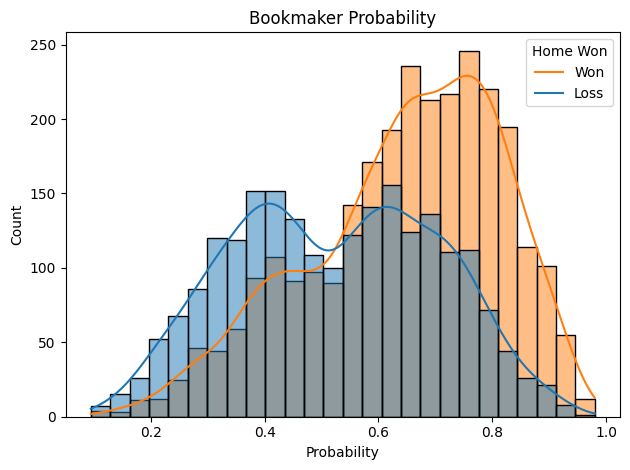

In [6]:
def moneyline_to_probability(moneyline):
    if moneyline < 0:
        return abs(moneyline)/(abs(moneyline)+100)
    return 100/(abs(moneyline)+100)
    

df_subset['moneyline_prob'] = df_subset['tm_won_moneyline'].apply(moneyline_to_probability)

sns.histplot(data=df_subset, x='moneyline_prob', hue='home_won', kde=True)
plt.title('Bookmaker Probability')
plt.xlabel('Probability')
plt.legend(title='Home Won', labels=['Won', 'Loss'])
plt.tight_layout()
plt.show()

### Previous Season Records

In [7]:
home_df = df_subset[['season', 'week', 'home_team', 'home_won']].rename(columns={'home_team': 'tm', 'home_won': 'won'})
away_df = df_subset[['season', 'week', 'away_team', 'away_won']].rename(columns={'away_team': 'tm', 'away_won': 'won'})
wins_df = pd.concat([home_df, away_df]).reset_index(drop=True)
wins_df.head()

,season,week,tm,won
0,1999,1,ATL,0
1,1999,1,CHI,1
2,1999,1,CLE,0
3,1999,1,GB,1
4,1999,1,IND,1


In [8]:
wins_group = wins_df.groupby(['tm', 'season'])
wins_percent = wins_group['won'].value_counts(normalize=True)
wins_percent

tm   season  won
ARI  1999    0      0.625000
             1      0.375000
     2000    0      0.812500
             1      0.187500
     2001    0      0.562500
                      ...   
WAS  2022    0      0.470588
     2023    0      0.764706
             1      0.235294
     2024    1      0.700000
             0      0.300000
Name: proportion, Length: 1656, dtype: float64

In [9]:
df_subset = df_subset[(df_subset['season'] > 2010) & (df_subset['game_type'] == 'REG')].reset_index(drop=True)
df_subset.drop(columns=['home_moneyline', 'away_moneyline', 'home_score', 'away_score', 'away_won', 'game_type', 'gameday', 'gametime'], inplace=True)

In [10]:
def previous_season_win_percent(season, team_abbr):
    try:
        percent = wins_percent.loc[team_abbr, season-1][1]
    except KeyError:
        percent = 0
    finally:
        return percent
    
df_subset['win_perct_h'] = df_subset.apply(lambda df: previous_season_win_percent(df['season'], df['home_team']), axis=1)
df_subset['win_perct_a'] = df_subset.apply(lambda df: previous_season_win_percent(df['season'], df['away_team']), axis=1)
df_subset.head()

,season,week,weekday,home_team,away_team,tm_won_moneyline,home_won,moneyline_prob,win_perct_h,win_perct_a
0,2011,1,Thursday,GB,NO,-250.0,1,0.714286,0.700000,0.647059
1,2011,1,Sunday,BAL,PIT,-125.0,1,0.555556,0.722222,0.736842
2,2011,1,Sunday,CHI,ATL,105.0,1,0.487805,0.666667,0.764706
3,2011,1,Sunday,CLE,CIN,273.0,0,0.268097,0.312500,0.250000
4,2011,1,Sunday,HOU,IND,-430.0,1,0.811321,0.375000,0.588235


### Encoding

In [11]:
df_subset['weekday'] = np.where(df_subset['weekday'] == 'Sunday', 'Sunday', 'Not Sunday')
df_subset['weekday'].value_counts()

weekday
Sunday        3063
Not Sunday     584
Name: count, dtype: int64

In [12]:
df_subset['weekday'] = pd.get_dummies(df_subset['weekday'], dtype=int, drop_first=True)

In [13]:
predict_df = df_subset.copy()
predict_df = predict_df[predict_df['season'] >= 2023].reset_index(drop=True)
predict_df.head()

,season,week,weekday,home_team,away_team,tm_won_moneyline,home_won,moneyline_prob,win_perct_h,win_perct_a
0,2023,1,0,KC,DET,164.0,0,0.378788,0.850000,0.529412
1,2023,1,1,ATL,CAR,-192.0,1,0.657534,0.411765,0.411765
2,2023,1,1,BAL,HOU,-500.0,1,0.833333,0.555556,0.176471
3,2023,1,1,CLE,CIN,-108.0,1,0.519231,0.411765,0.736842
4,2023,1,1,IND,JAX,-205.0,0,0.672131,0.294118,0.526316


In [14]:
def encode_teams(df, column_name):
    temp_df = pd.get_dummies(df[column_name], dtype=int)
    new_columns =  temp_df.columns.str.lower() + '_' + column_name.split('_')[0][0]
    temp_df.columns = new_columns
    return temp_df

home_tm_enc = encode_teams(df_subset, 'home_team')
away_tm_enc = encode_teams(df_subset, 'away_team')

df_subset.drop(columns=['home_team', 'away_team', 'moneyline_prob'], inplace=True)

In [15]:
nfl_df = pd.concat([home_tm_enc, away_tm_enc, df_subset], axis=1)
nfl_df.head()

,ari_h,atl_h,bal_h,buf_h,car_h,chi_h,cin_h,cle_h,dal_h,den_h,...,tb_a,ten_a,was_a,season,week,weekday,tm_won_moneyline,home_won,win_perct_h,win_perct_a
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2011,1,0,-250.0,1,0.700000,0.647059
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,2011,1,1,-125.0,1,0.722222,0.736842
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,2011,1,1,105.0,1,0.666667,0.764706
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,2011,1,1,273.0,0,0.312500,0.250000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2011,1,1,-430.0,1,0.375000,0.588235


## Machine Learning

In [16]:
year_filter = 2022
training_set = nfl_df[year_filter >= nfl_df['season']]
testing_set = nfl_df[year_filter < nfl_df['season']]

x_train = training_set.drop(columns=['season', 'tm_won_moneyline', 'home_won'])
y_train = training_set['home_won']
x_test = testing_set.drop(columns=['season', 'tm_won_moneyline', 'home_won'])
y_test = testing_set['home_won']

print(f'Training size: {training_set.shape[0]}')
print(f'Testing size: {testing_set.shape[0]}')

Training size: 3103
Testing size: 544


In [17]:
lr = LogisticRegression()
xgb = XGBClassifier()

In [18]:
lr.fit(x_train, y_train)
xgb.fit(x_train, y_train)

lr_preds = lr.predict(x_test)
xgb_preds = xgb.predict(x_test)
lr_accuracy_score = accuracy_score(y_test, lr_preds)
xgb_accuracy_score = accuracy_score(y_test, xgb_preds)

print(f'Logistic Regression: {lr_accuracy_score.__round__(3)}')
print(f'XGB: {xgb_accuracy_score.__round__(3)}')

Logistic Regression: 0.596
XGB: 0.581


### Model Report

In [19]:
lr_report = classification_report(y_test, lr_preds)
xgb_report = classification_report(y_test, xgb_preds)

print('Logistic Regression Report\n')
print(lr_report)
print('-'*55)
print('XGB Classifier Report\n')
print(xgb_report)

Logistic Regression Report

              precision    recall  f1-score   support

           0       0.57      0.45      0.50       248
           1       0.61      0.72      0.66       296

    accuracy                           0.60       544
   macro avg       0.59      0.58      0.58       544
weighted avg       0.59      0.60      0.59       544

-------------------------------------------------------
XGB Classifier Report

              precision    recall  f1-score   support

           0       0.55      0.49      0.51       248
           1       0.61      0.66      0.63       296

    accuracy                           0.58       544
   macro avg       0.58      0.57      0.57       544
weighted avg       0.58      0.58      0.58       544



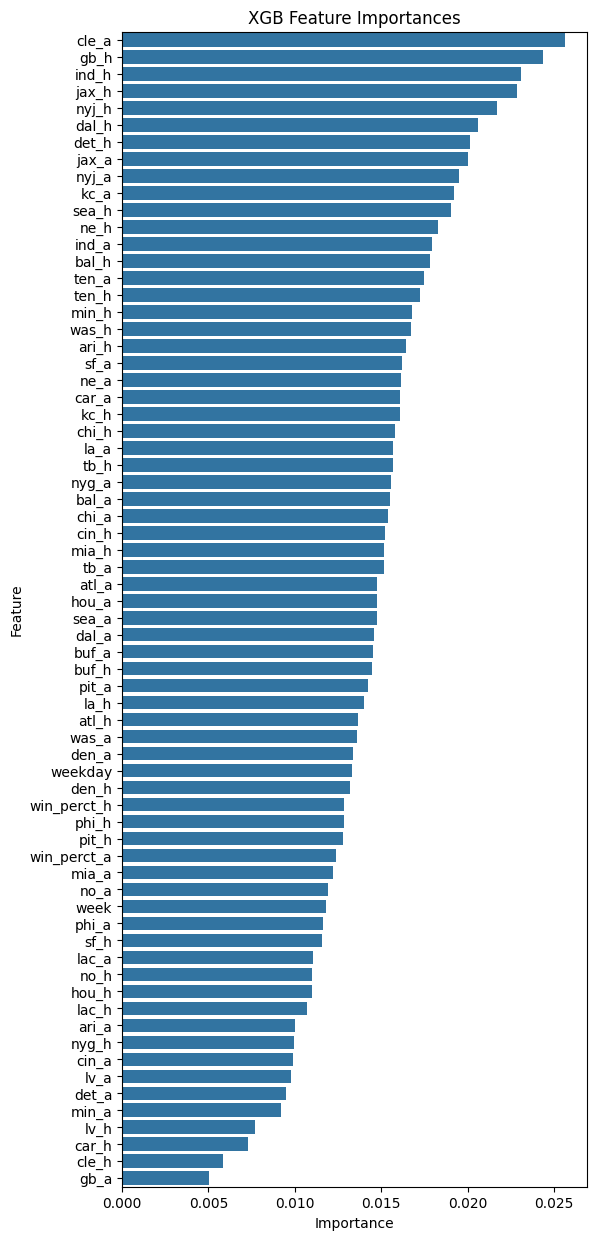

In [20]:
importances = {}
for key, value in zip(xgb.feature_names_in_, xgb.feature_importances_):
    importances[key] = value

plt.figure(figsize=(6, 15))
plt.title('XGB Feature Importances')
sns.barplot(
    data=pd.DataFrame(importances.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False),
    x='Importance',
    y='Feature'
    )
plt.show()

### Results

In [21]:
home = encode_teams(predict_df, 'home_team')
away = encode_teams(predict_df, 'away_team')
df_sub = predict_df[['week', 'weekday', 'win_perct_h', 'win_perct_a']]

In [22]:
pred_df = pd.concat([home, away, df_sub], axis=1)
pred_vals = xgb.predict(pred_df)
predict_prob = xgb.predict_proba(pred_df).max(axis=1)

predict_df['prediction'] = pred_vals
display_df = predict_df

display_df['season_prob'] = np.where(display_df['home_won'] == 1, display_df['win_perct_h'], display_df['win_perct_a'])
display_df['model_prob'] = predict_prob
display_df['model_pred'] = np.where(display_df['prediction'] == 1, 'Home', 'Away')
display_df['won'] = np.where(display_df['home_won'] == 1, 'Home', 'Away')

display_df['outcome'] = np.where(
    (
        (display_df['home_won'] == 1) & (display_df['prediction'] == 1)
    ) | (
        (display_df['home_won'] == 0) & (display_df['prediction'] == 0)
    )
    , 
    'Correct',
    'Wrong'
    )

In [23]:
display_df.drop(columns=['weekday', 'home_won', 'tm_won_moneyline', 'win_perct_a', 'win_perct_h', 'prediction'], inplace=True)
display_df.head()

,season,week,home_team,away_team,moneyline_prob,season_prob,model_prob,model_pred,won,outcome
0,2023,1,KC,DET,0.378788,0.529412,0.780411,Home,Away,Wrong
1,2023,1,ATL,CAR,0.657534,0.411765,0.510085,Home,Home,Correct
2,2023,1,BAL,HOU,0.833333,0.555556,0.881606,Home,Home,Correct
3,2023,1,CLE,CIN,0.519231,0.411765,0.921295,Away,Home,Wrong
4,2023,1,IND,JAX,0.672131,0.526316,0.608356,Home,Away,Wrong


In [24]:
display_df['model_prob_diff'] = display_df['model_prob'] - display_df['moneyline_prob']

In [25]:
display_df.columns = display_df.columns.str.replace('_', ' ').str.title()

In [26]:
display_df['Outcome'].value_counts(normalize=True)

Outcome
Correct    0.580882
Wrong      0.419118
Name: proportion, dtype: float64

In [27]:
display_df.groupby(['Season', 'Model Pred'])['Outcome'].value_counts(normalize=True)

Season  Model Pred  Outcome
2023    Away        Wrong      0.524590
                    Correct    0.475410
        Home        Correct    0.580000
                    Wrong      0.420000
2024    Away        Correct    0.630000
                    Wrong      0.370000
        Home        Correct    0.627907
                    Wrong      0.372093
Name: proportion, dtype: float64

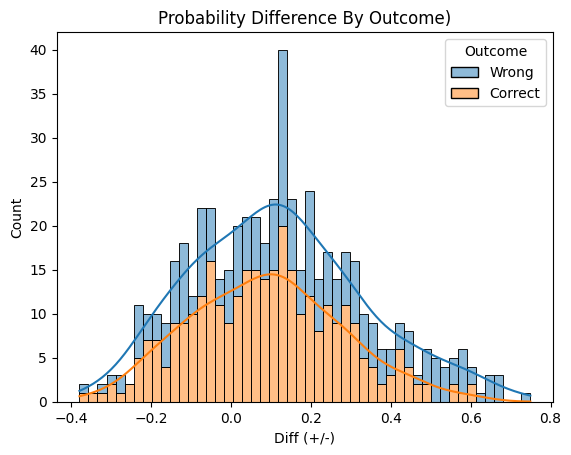

In [28]:
sns.histplot(data=display_df, x='Model Prob Diff', hue='Outcome', multiple='stack', kde=True, bins=50)
plt.title('Probability Difference By Outcome)')
plt.xlabel('Diff (+/-)')
plt.show()

In [29]:
joblib.dump(value=xgb, filename='model.joblib')

['model.joblib']